# XGBoost Regression Analysis

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

## Import Data

In [2]:
df = pd.read_parquet('data/combined_files.parquet')
df.head()

,power,knoxville_temperature_2m,knoxville_relative_humidity_2m,knoxville_precipitation,knoxville_rain,knoxville_snowfall,knoxville_snow_depth,knoxville_apparent_temperature,knoxville_cloud_cover,knoxville_wind_speed_10m,...,month,day_percent,hour,season_Fall,season_Spring,season_Summer,season_Winter,runtime,power_1hr,power_1day
0,13510,44.399300,95.629303,0.0,0.0,0.0,0.0,39.823086,0.0,1.890231,...,1,0.064516,0,False,False,False,True,24.0,13902.0,14421.0
1,13114,45.749298,94.351883,0.0,0.0,0.0,0.0,42.451595,13.0,1.200324,...,1,0.064516,1,False,False,False,True,25.0,13510.0,13940.0
2,12887,45.299301,94.991661,0.0,0.0,0.0,0.0,42.088787,4.0,1.101308,...,1,0.064516,2,False,False,False,True,26.0,13114.0,13621.0
3,12737,44.219299,95.956245,0.0,0.0,0.0,0.0,40.415550,51.0,1.368721,...,1,0.064516,3,False,False,False,True,27.0,12887.0,13406.0
4,12834,47.369301,91.849159,0.0,0.0,0.0,0.0,43.957150,39.0,1.417247,...,1,0.064516,4,False,False,False,True,28.0,12737.0,13258.0


In [3]:
# create date info for visualizations later
df_visuals = df[['year', 'month', 'hour', 'day_percent']].copy()
df_visuals['day'] = 1
df_visuals['first_of_month'] = pd.to_datetime(df_visuals[['year', 'month', 'day']])
df_visuals['day'] = df_visuals['day_percent'] * df_visuals['first_of_month'].dt.daysinmonth
df_visuals['date_no_hour'] = pd.to_datetime(df_visuals[['year', 'month', 'day']])
df_visuals['date'] = df_visuals['date_no_hour'] + pd.to_timedelta(df_visuals['hour'], unit='h')
df_visuals.head()

,year,month,hour,day_percent,day,first_of_month,date_no_hour,date
0,2023,1,0,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 00:00:00
1,2023,1,1,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 01:00:00
2,2023,1,2,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 02:00:00
3,2023,1,3,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 03:00:00
4,2023,1,4,0.064516,2.0,2023-01-01,2023-01-02,2023-01-02 04:00:00


## Split Into Test/Train

In [4]:
X = df.drop(columns='power')
y = df[['power']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=13)

In [5]:
# make dataframes for test/train visualizations
df_visuals_train = df_visuals.loc[X_train.index]
df_visuals_test = df_visuals.loc[X_test.index]

## Run initial model

In [6]:
model = XGBRegressor(random_state=13)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [7]:
# get results
print('Training Results')
print('R2 Train:', r2_score(y_train, y_pred_train))
print('RMSE Train:', root_mean_squared_error(y_train, y_pred_train))
print('MAPE Train:', mean_absolute_percentage_error(y_train, y_pred_train))

print('\nTest Results:')
print('R2 Test:', r2_score(y_test, y_pred))
print('RMSE Test:', root_mean_squared_error(y_test, y_pred))
print('MAPE Test:', mean_absolute_percentage_error(y_test, y_pred))

Training Results
R2 Train: 0.9989833235740662
RMSE Train: 119.87234497070312
MAPE Train: 0.005046646110713482

Test Results:
R2 Test: 0.9960551857948303
RMSE Test: 237.3669891357422
MAPE Test: 0.009343331679701805


In [8]:
df_test = pd.concat([df_visuals_test[['date']], y_test], axis=1)
df_test.rename(columns={'date': 'Date', 'power': 'Actual'}, inplace=True)
df_test['Predicted'] = y_pred
df_test

,Date,Actual,Predicted
16291,2024-11-10 20:00:00,16453,16560.996094
890,2023-02-08 02:00:00,14295,14420.894531
9649,2024-02-08 02:00:00,16366,16486.304688
14275,2024-08-18 22:00:00,21727,21825.193359
7731,2023-11-20 02:00:00,14581,14581.067383
...,...,...,...
3574,2023-05-30 23:00:00,17706,17897.880859
10625,2024-03-19 18:00:00,16952,16858.560547
8715,2023-12-31 02:00:00,18699,18916.648438
10089,2024-02-26 09:00:00,17284,17581.035156


Text(0.5, 1.0, 'Residuals vs Predicted - XGBoost')

<Figure size 1200x1000 with 0 Axes>

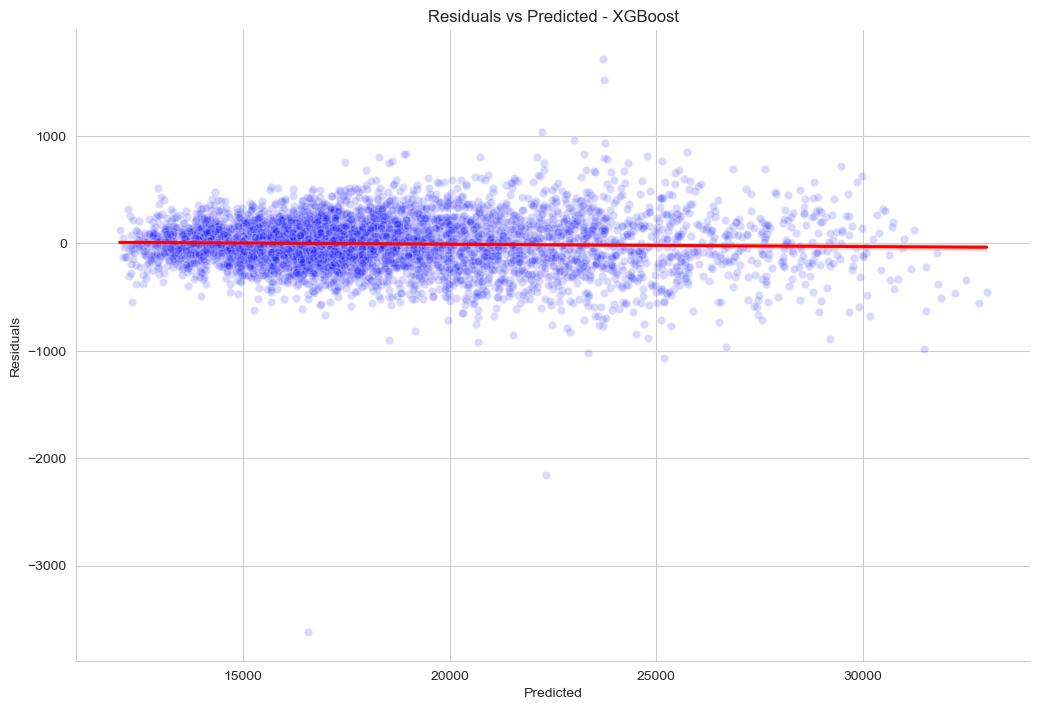

In [9]:
# create dataframe
df_test = pd.concat([df_visuals_test[['date']], y_test], axis=1)
df_test.rename(columns={'date': 'Date', 'power': 'Actual'}, inplace=True)
df_test['Predicted'] = y_pred

# plot residuals
plt.figure(figsize=(12,10))
df_test['Residuals'] = df_test['Actual'] - df_test['Predicted']
sns.lmplot(x='Predicted', y='Residuals', data=df_test, height=7,
          aspect=1.5, scatter_kws={'alpha': 0.15, 'color': 'blue', 'edgecolor': 'white'},
          line_kws={'color': 'red'})
plt.title('Residuals vs Predicted - XGBoost')

In [10]:
df_test[(df_test['Residuals']<-1000)|(df_test['Residuals']>1000)]

,Date,Actual,Predicted,Residuals
8843,2024-01-05 10:00:00,24121,25185.935547,-1064.935547
4332,2023-07-01 13:00:00,25251,23725.082031,1525.917969
14729,2024-09-06 19:00:00,22314,23337.826172,-1023.826172
13114,2024-07-01 12:00:00,23276,22238.656250,1037.343750
13317,2024-07-10 00:00:00,20167,22320.908203,-2153.908203
2569,2023-04-19 02:00:00,12946,16565.400391,-3619.400391
13808,2024-07-30 11:00:00,25439,23718.613281,1720.386719


In [11]:
# look at feature importance
df_features = pd.DataFrame({'Features': list(X.columns),
                            'Values': model.feature_importances_})
df_features.sort_values(by='Values', ascending=False).head(10)

,Features,Values
54,power_1hr,0.878887
28,nashville_temperature_2m,0.016130
48,hour,0.014821
37,nashville_is_day,0.008410
51,season_Summer,0.008037
9,knoxville_is_day,0.007625
23,memphis_is_day,0.007318
6,knoxville_apparent_temperature,0.006232
34,nashville_apparent_temperature,0.006134
55,power_1day,0.006015


## Hyperparamter Tuning

In [12]:
# warning - takes around an hour to run on my laptop
param_grid = {
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'random_state': [13]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'random_state': 13, 'subsample': 0.8}


In [13]:
model = XGBRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [14]:
# get results
print('Training Results')
print('R2 Train:', r2_score(y_train, y_pred_train))
print('RMSE Train:', root_mean_squared_error(y_train, y_pred_train))
print('MAPE Train:', mean_absolute_percentage_error(y_train, y_pred_train))

print('\nTest Results:')
print('R2 Test:', r2_score(y_test, y_pred))
print('RMSE Test:', root_mean_squared_error(y_test, y_pred))
print('MAPE Test:', mean_absolute_percentage_error(y_test, y_pred))

Training Results
R2 Train: 0.9996723532676697
RMSE Train: 68.04751586914062
MAPE Train: 0.0029123348649591208

Test Results:
R2 Test: 0.9970974326133728
RMSE Test: 203.61048889160156
MAPE Test: 0.00787714309990406


Text(0.5, 1.0, 'Residuals vs Predicted - XGBoost')

<Figure size 1200x1000 with 0 Axes>

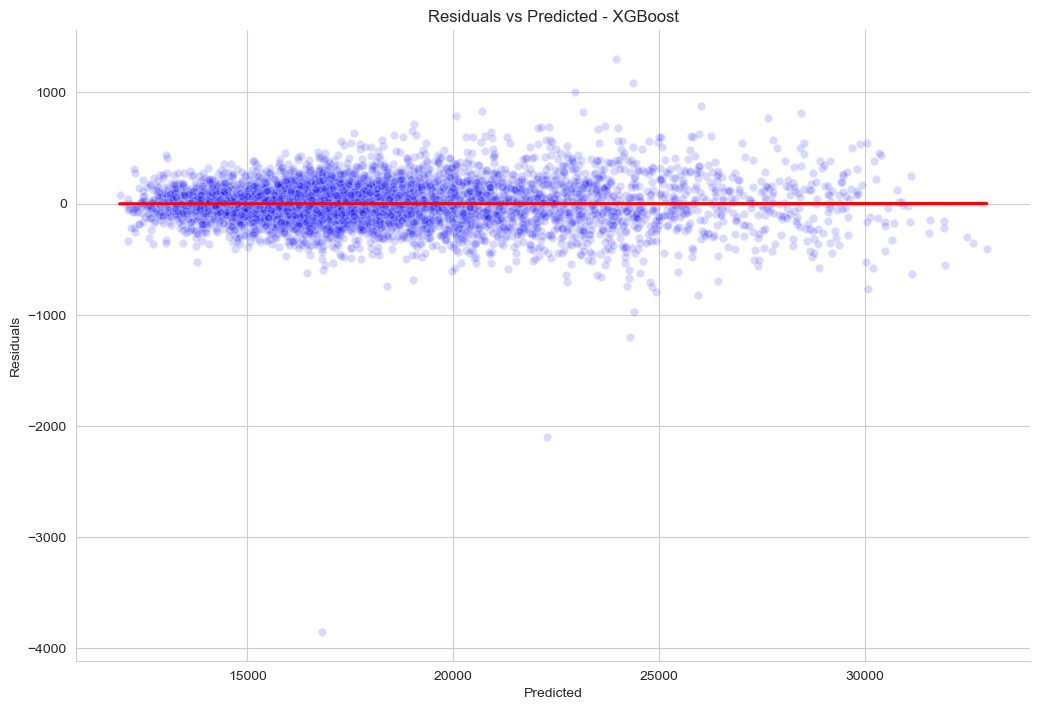

In [15]:
# create dataframe
df_test = pd.concat([df_visuals_test[['date']], y_test], axis=1)
df_test.rename(columns={'date': 'Date', 'power': 'Actual'}, inplace=True)
df_test['Predicted'] = y_pred

# plot residuals
plt.figure(figsize=(12,10))
df_test['Residuals'] = df_test['Actual'] - df_test['Predicted']
sns.lmplot(x='Predicted', y='Residuals', data=df_test, height=7,
          aspect=1.5, scatter_kws={'alpha': 0.15, 'color': 'blue', 'edgecolor': 'white'},
          line_kws={'color': 'red'})
plt.title('Residuals vs Predicted - XGBoost')

In [16]:
large_residuals = df_test[(df_test['Residuals']<-1000)|(df_test['Residuals']>1000)]
large_residuals

,Date,Actual,Predicted,Residuals
14657,2024-09-03 19:00:00,23967,22962.708984,1004.291016
4332,2023-07-01 13:00:00,25251,23947.568359,1303.431641
4817,2023-07-21 18:00:00,23092,24291.890625,-1199.890625
13317,2024-07-10 00:00:00,20167,22264.853516,-2097.853516
2569,2023-04-19 02:00:00,12946,16798.951172,-3852.951172
13808,2024-07-30 11:00:00,25439,24358.673828,1080.326172


In [17]:
# look at feature importance
df_features = pd.DataFrame({'Features': list(X.columns),
                            'Values': model.feature_importances_})
df_features.sort_values(by='Values', ascending=False).head(10)

,Features,Values
54,power_1hr,0.893366
48,hour,0.012890
37,nashville_is_day,0.012731
28,nashville_temperature_2m,0.011921
9,knoxville_is_day,0.010346
23,memphis_is_day,0.006991
51,season_Summer,0.005990
0,knoxville_temperature_2m,0.005939
34,nashville_apparent_temperature,0.005363
6,knoxville_apparent_temperature,0.003892


## Additional Testing

In [18]:
X = df.drop(columns=['power', 'power_1hr'])
y = df[['power']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=13)

In [19]:
# warning - takes around an hour to run on my laptop
param_grid = {
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'random_state': [13]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500, 'random_state': 13, 'subsample': 0.8}


In [20]:
model = XGBRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [21]:
# get results
print('Training Results')
print('R2 Train:', r2_score(y_train, y_pred_train))
print('RMSE Train:', root_mean_squared_error(y_train, y_pred_train))
print('MAPE Train:', mean_absolute_percentage_error(y_train, y_pred_train))

print('\nTest Results:')
print('R2 Test:', r2_score(y_test, y_pred))
print('RMSE Test:', root_mean_squared_error(y_test, y_pred))
print('MAPE Test:', mean_absolute_percentage_error(y_test, y_pred))

Training Results
R2 Train: 0.9981497526168823
RMSE Train: 161.71282958984375
MAPE Train: 0.006845851428806782

Test Results:
R2 Test: 0.9836246371269226
RMSE Test: 483.61785888671875
MAPE Test: 0.018606459721922874


Text(0.5, 1.0, 'Residuals vs Predicted - XGBoost')

<Figure size 1200x1000 with 0 Axes>

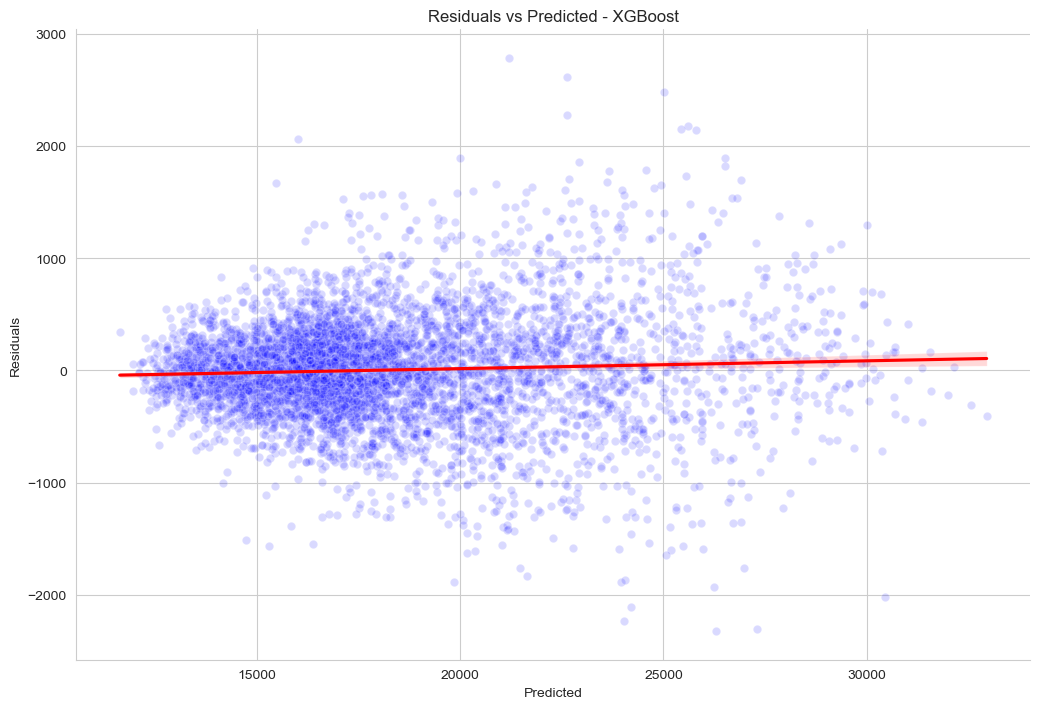

In [22]:
# create dataframe
df_test = pd.concat([df_visuals_test[['date']], y_test], axis=1)
df_test.rename(columns={'date': 'Date', 'power': 'Actual'}, inplace=True)
df_test['Predicted'] = y_pred

# plot residuals
plt.figure(figsize=(12,10))
df_test['Residuals'] = df_test['Actual'] - df_test['Predicted']
sns.lmplot(x='Predicted', y='Residuals', data=df_test, height=7,
          aspect=1.5, scatter_kws={'alpha': 0.15, 'color': 'blue', 'edgecolor': 'white'},
          line_kws={'color': 'red'})
plt.title('Residuals vs Predicted - XGBoost')

In [23]:
large_residuals = df_test[(df_test['Residuals']<-1000)|(df_test['Residuals']>1000)]
large_residuals

,Date,Actual,Predicted,Residuals
4269,2023-06-28 22:00:00,23083,21961.789062,1121.210938
14146,2024-08-13 13:00:00,25516,24053.505859,1462.494141
4822,2023-07-21 23:00:00,18712,19712.761719,-1000.761719
9487,2024-02-01 08:00:00,25582,24022.759766,1559.240234
16854,2024-12-04 07:00:00,26900,25824.015625,1075.984375
...,...,...,...,...
13210,2024-07-05 12:00:00,23979,26301.646484,-2322.646484
12967,2024-06-25 09:00:00,20151,21330.830078,-1179.830078
10640,2024-03-20 09:00:00,18719,19998.429688,-1279.429688
4477,2023-07-07 14:00:00,25816,24645.818359,1170.181641


In [24]:
# look at feature importance
df_features = pd.DataFrame({'Features': list(X.columns),
                            'Values': model.feature_importances_})
df_features.sort_values(by='Values', ascending=False).head(10)

,Features,Values
19,memphis_snow_depth,0.562127
54,power_1day,0.145647
28,nashville_temperature_2m,0.071378
34,nashville_apparent_temperature,0.052837
52,season_Winter,0.020649
48,hour,0.018610
44,is_weekend,0.014056
37,nashville_is_day,0.013191
23,memphis_is_day,0.009736
20,memphis_apparent_temperature,0.009346
